In [1]:
import pandas
import sys
import warnings
import ee
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
# import local modules
sys.path.append('../src')
from Fishnet import Fishnet
from ImageExporter import ImageExporter
from ImageCorrector import ImageCorrector
from ImageProcessor import ImageProcessor

# update files automatically
%load_ext autoreload
%autoreload 2
pandas.set_option('display.max_columns', 500)

# Load complete Fishnet

In [3]:
fc = Fishnet.load('../Gis/Fishnet/fishnet_quarter_mile_completed.pkl')

In [4]:
# Compute Urbanization Rate
for year in [2017, 2018, 2019, 2020, 2021, 2022]:
    fc.compute_difference(f'MeanPixel_{year}', f'MeanPixel_{year-1}', filtered=True, normalize = True)

fc.filtered_fishnet.rename(columns={'MeanPixel_2022-MeanPixel_2021': 'UrbanizationRate2022'}, inplace=True)
fc.filtered_fishnet.rename(columns={'MeanPixel_2021-MeanPixel_2020': 'UrbanizationRate2021'}, inplace=True)
fc.filtered_fishnet.rename(columns={'MeanPixel_2020-MeanPixel_2019': 'UrbanizationRate2020'}, inplace=True)
fc.filtered_fishnet.rename(columns={'MeanPixel_2019-MeanPixel_2018': 'UrbanizationRate2019'}, inplace=True)
fc.filtered_fishnet.rename(columns={'MeanPixel_2018-MeanPixel_2017': 'UrbanizationRate2018'}, inplace=True)
fc.filtered_fishnet.rename(columns={'MeanPixel_2017-MeanPixel_2016': 'UrbanizationRate2017'}, inplace=True)
fc.filtered_fishnet.drop(columns=['MeanPixel_2021-MeanPixel_2016'], inplace=True)

In [5]:
fc.filtered_fishnet.head(3)

,id,geometry,batch_id,neighbors,ImageCoordinates,Width,Height,MeanPixel_2016,Entropy_2016,MeanPixel_2017,Entropy_2017,MeanPixel_2018,Entropy_2018,MeanPixel_2019,Entropy_2019,MeanPixel_2020,Entropy_2020,MeanPixel_2021,Entropy_2021,MeanPixel_2022,Entropy_2022,UrbanizationRate2017,UrbanizationRate2018,UrbanizationRate2019,UrbanizationRate2020,UrbanizationRate2021,UrbanizationRate2022
6060154,6060154.0,"POLYGON ((-95.79985 29.79208, -95.79985 29.795...",23743.0,"[6056884, 6056885, 6056886, 6060153, 6060155, ...","(403, 524, 448, 564)",45.0,40.0,181.191667,0.868003,197.341667,0.771170,222.275000,0.552850,219.583333,0.581321,225.958333,0.511536,233.041667,0.423354,237.008333,0.367993,0.063333,0.097778,-0.010556,0.025000,0.027778,0.015556
6060155,6060155.0,"POLYGON ((-95.79583 29.79208, -95.79583 29.795...",23743.0,"[6056885, 6056886, 6056887, 6060154, 6060156, ...","(448, 524, 492, 564)",44.0,40.0,204.724432,0.716210,213.272727,0.642938,229.355114,0.470794,228.485795,0.481478,230.948864,0.450721,237.613636,0.359102,241.815341,0.293594,0.033523,0.063068,-0.003409,0.009659,0.026136,0.016477
6060156,6060156.0,"POLYGON ((-95.79181 29.79208, -95.79181 29.795...",23743.0,"[6056886, 6056887, 6056888, 6060155, 6060157, ...","(492, 524, 537, 564)",45.0,40.0,140.250000,0.992774,133.025000,0.998645,136.708333,0.996234,147.333333,0.982474,148.750000,0.979869,168.583333,0.923751,168.583333,0.923751,-0.028333,0.014444,0.041667,0.005556,0.077778,0.000000


# Which image size do we want?

Text(0.5, 0, 'Height (pixels)')

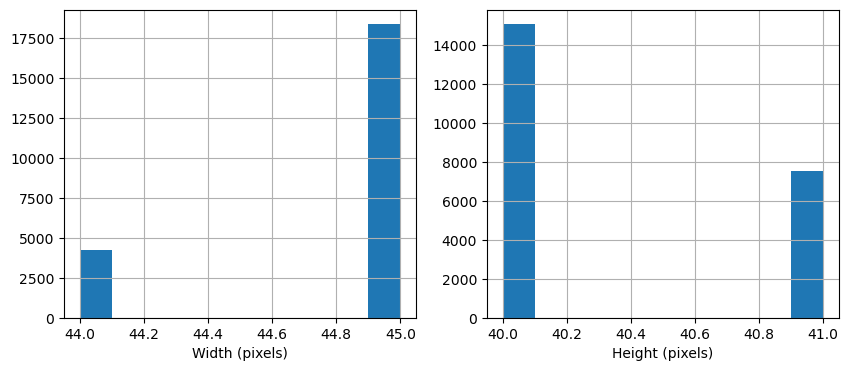

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 4))
plt.subplot(121)
fc.filtered_fishnet["Width"].hist()
plt.xlabel('Width (pixels)')
plt.subplot(122)
fc.filtered_fishnet["Height"].hist()
plt.xlabel('Height (pixels)')

# Export batch images into smaller images and store them locally

In [7]:
img_process = ImageProcessor(
    fc,
    filtered=True,
)

if False:
    for year in tqdm([2016, 2017, 2018, 2019, 2020, 2021, 2022]):
        img_process.cnn_partition_images(
            image_folder="../Images2/",
            file_name="landcover_batchID",
            year=year,
            img_size=[40, 44],
            warning=False,
            show_progress=False,
        )

# Convolutional Neural Network

Train a CNN to predict next year urbanization based on single image

In [8]:
vars = ["id", "batch_id", "UrbanizationRate2017", "UrbanizationRate2018", "UrbanizationRate2019", "UrbanizationRate2020", "UrbanizationRate2021", "UrbanizationRate2022"]
data = fc.filtered_fishnet[vars]
data.rename(columns={"id": "tile_id"}, inplace=True)
data["tile_id"] = data["tile_id"].astype(int)
data["batch_id"] = data["batch_id"].astype(int)

# Pivot wide to long
data = data.melt(id_vars=["tile_id", "batch_id"], var_name="year", value_name="urbanization_rate")
data["year"] = data["year"].str[-4:]
data.head()

,tile_id,batch_id,year,urbanization_rate
0,6060154,23743,2017,0.063333
1,6060155,23743,2017,0.033523
2,6060156,23743,2017,-0.028333
3,6060157,23743,2017,-0.052778
4,6060158,23743,2017,0.006667


In [9]:
# from custom_dataset import CustomDataset

# import torch
# from torch.utils.data import Dataset, DataLoader
# from PIL import Image

In [10]:

# data_loader = DataLoader(
#     data,
#     batch_size=batch_size,
#     shuffle=shuffle,
#     num_workers=num_workers,
# )

# Train / Test Split

In [11]:
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

from custom_dataset import CustomDataset

In [65]:
# Split dataset into training and test subsets
test_ratio = 0.1 
val_ratio = 0.05
train_val_data, test_data = train_test_split(data, test_size=test_ratio)
train_data, val_data = train_test_split(train_val_data, test_size=val_ratio)

# Create DataLoaders for training and test sets
base_path = "../Images2/CNN"
train_data = CustomDataset(base_path, train_data)
val_data = CustomDataset(base_path, val_data)
test_data = CustomDataset(base_path, test_data)

batch_size = 32    # Adjust according to your available resources
shuffle = True     # Set to True if you want to shuffle the dataset during training
num_workers = 1    # Number of worker threads for data loading

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=val_data.__len__(), shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.__len__(), shuffle=True)

In [66]:
train_data.__len__()

115840

In [67]:
val_data.__len__()

6097

In [68]:
test_data.__len__()

13549

In [69]:
train_loader.__len__()

3620

In [74]:
# Sanity checks for data loader 

# for images, targets in data_loader:
#     # Print batch shape
#     print("Batch of Images:", images.shape)
#     print("Batch of Targets:", targets.shape)


# Tensorboard

In [75]:
from torch.utils.tensorboard import SummaryWriter

# Train the CNN

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim

In [77]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc = nn.Linear(32 * 10 * 11, 1)  

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    
# Create an instance of your CNN
model = CNN()

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=runs

In [82]:
writer = SummaryWriter()
num_epochs = 10  # Set the number of training epochs

for epoch in tqdm(range(num_epochs)):
    running_loss = 0.0
    for i, train_data in tqdm(enumerate(train_loader, 0)):
        # Get the inputs and labels from your data loader
        X_batch, y_batch = train_data

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass + backward pass + optimize
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        writer.add_scalar('Loss/Train', loss.item(), epoch * len(train_loader) + i)

        # Print training statistics
        # running_loss += loss.item()
        # if i % 100 == 99:  # Print every 100 mini-batches
        #     print(f'Training - Epoch: {epoch + 1}, Batch: {i + 1}, Train Loss: {running_loss / 100}')
        #     running_loss = 0.0

        # Evaluate on the validation dataset
        with torch.no_grad():
            test_data = next(iter(val_loader))
            X_test_batch, y_test_batch = test_data
            outputs = model(X_test_batch)
            loss = criterion(outputs, y_test_batch)
            writer.add_scalar('Loss/Validation', loss.item(), epoch * len(train_loader) + i)
            

            # test_data = next(iter(val_loader))
            # test_outputs = model(X_test_batch)
            # test_loss = criterion(test_outputs, y_test_batch).item()
            # # print(f'Testing - Epoch: {epoch + 1}, Batch: {i + 1}, Test Loss: {test_loss}')

writer.close()

367it [1:44:52, 17.15s/it] 0<?, ?it/s]
  0%|          | 0/10 [1:44:52<?, ?it/s]


KeyboardInterrupt: 

In [23]:
# connect to TensorBoard

In [28]:
next(iter(train_loader))

[tensor([[[[ 57.,  57., 136.,  ..., 196., 196., 196.],
           [ 57.,  57., 136.,  ..., 196., 196., 196.],
           [ 57.,  57., 136.,  ..., 196., 196., 196.],
           ...,
           [ 57.,  57., 136.,  ..., 196., 196., 196.],
           [ 57.,  57., 136.,  ..., 196., 196., 196.],
           [ 57.,  57., 136.,  ..., 196., 196., 196.]],
 
          [[125., 125., 176.,  ...,  40.,  40.,  40.],
           [125., 125., 176.,  ...,  40.,  40.,  40.],
           [125., 125., 176.,  ...,  40.,  40.,  40.],
           ...,
           [125., 125., 176.,  ...,  40.,  40.,  40.],
           [125., 125., 176.,  ...,  40.,  40.,  40.],
           [125., 125., 176.,  ...,  40.,  40.,  40.]],
 
          [[ 73.,  73.,  83.,  ...,  27.,  27.,  27.],
           [ 73.,  73.,  83.,  ...,  27.,  27.,  27.],
           [ 73.,  73.,  83.,  ...,  27.,  27.,  27.],
           ...,
           [ 73.,  73.,  83.,  ...,  27.,  27.,  27.],
           [ 73.,  73.,  83.,  ...,  27.,  27.,  27.],
           

In [31]:
next(iter(val_loader))

for batch_idx, data in enumerate(train_loader):
    print("batch idx{}, batch len {}".format(batch_idx, len(data)))

KeyError: 0

In [198]:
val_loader
len(val_loader)

for i in enumerate(val_loader, 0):
    print(i)

KeyError: 0

In [ ]:
writer = SummaryWriter()


In [200]:
val_loader.__len__()

1